## **Objective**

Implement a comprehensive function to analyze the data distribution in Data1.txt by calculating essential statistics and performing a sophisticated outlier analysis using the Interquartile Range (IQR). This analysis will include an “Outlier Scoring” system to classify different levels of outliers and explore how these affect various statistical measures. You will also use visualization to illustrate the data distribution and the effect of removing different levels of outliers.


In [1]:
# Importing Basic libraries for reading data, Counter for Mode calculation, 
# Pandas for dataframing, Numpy & Matplot lib for visualizations and data transformations
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define Helper functions to get Basic Statistical Measures & visualizations - then store values in a dictionary for comparison

# 1- Define Median (the middle value of a sorted value list )
def get_median(data):
    n = len(data) # Get total number of data points
    if n == 0:
        return 0.0 # Handle empty list case
    
    if n % 2 == 1: # if an Odd Median value return the middle number then data splits cleanly
        median_index = n // 2
        median_odd = data[median_index] 
        return median_odd
    else: # if an even Median value return the avg of the 2 middle numbers
        upper_median_value = n // 2
        lower_median_value = upper_median_value - 1
        median_even = (data[upper_median_value] + data[lower_median_value]) / 2
        return median_even

# 2- Define Mode (the most common value in the dataset) count each occurrence of the data point and get data point with the maximum occurrence 
def get_mode(data):
    # Handle empty list case
    if not data:
        return []
    counts = Counter(data)
    max_count = max(counts.values()) 
    mode = [i for i, count in counts.items() if count == max_count]
    return mode

# 3- Define get stats 
def get_stats(data):
    """Calculates Mean, Median, and Standard Deviation for a list of data."""
    N = len(data)
    if N == 0:
        return 0.0, 0.0, 0.0
    # Mean (sum of data values divided by their over-all count )
    mean_value = sum(data) / N

    # Median
    median_value = get_median(data) 
    
    # Variance and Standard Deviation 
    # Calculate the (Sum of Squared Differences from the mean value for each data-point) and divide by N
    squared_differences_sum = sum((x - mean_value)**2 for x in data)
    variance = squared_differences_sum / N
    std_dev = (variance)**0.5 # Square-Root of Variance
    
    # Round results for cleaner storage
    return round(mean_value, 2), round(median_value, 2), round(variance, 2), round(std_dev, 2)

# 4- Get Quartiles
def calculate_quartiles_and_iqr(data):
    """
    Calculates Q1, Q3, and IQR for a sorted list of data .
    """
    N = len(data)
    
    # --- 1. Calculate Q1 (Median of the Lower Half) ---
    lower_half = data[:N // 2]
    Q1 = get_median(lower_half)

    # --- 2. Define the Upper Half Slice ---
    if N % 2 == 1:
        # Odd N: The median is EXCLUDED.
        upper_half = data[N // 2 + 1:]
    else:
        # Even N: The data splits cleanly.
        upper_half = data[N // 2:]

    # --- 3. Calculate Q3 (Median of the Upper Half) ---
    Q3 = get_median(upper_half)

    # --- 4. Calculate IQR ---
    IQR = Q3 - Q1
    return Q1, Q3, IQR


# 5- Outlier Detection, Scoring, and Classification:
#	Identify outliers using the IQR method:
#	Outliers: Values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR.
#	Extreme Outliers: Values beyond Q1 - 3×IQR or Q3 + 3×IQR.

def calculate_outlier_score(data, Q1_val, Q3_val, IQR_val):
    outlier_score = []
    
    lower_bound_outliers = Q1_val - 1.5 * IQR_val
    upper_bound_outliers = Q3_val + 1.5 * IQR_val
    
    # Outlier Score 
    for x in data:
        score = 0.0
        if x > upper_bound_outliers:
            score = (x - Q3_val)/IQR_val
        elif x < lower_bound_outliers:
            score = (Q1_val - x)/IQR_val
        outlier_score.append(round(score, 2))
    return outlier_score
    
# Classify Scores to "Extreme", "High" & "Moderate"
def classify_outlier_score(score):
    abs_score = abs(score) 

    if abs_score > 5.0:
        return "Extreme"
    elif abs_score > 3.0:
        return "High"
    elif abs_score > 1.5:
        return "Moderate"
    else:
        return "Not an Outlier"
        
# Create a DataFrame for outliers to get an itemized list of identified outliers with their scores and classifications
def create_outlier_dataframe(data_points, scores, categories):
    """
    Creates and filters a DataFrame listing only the outliers (Score > 1.5).
    """
    # Check if lists are the same length
    if not (len(data_points) == len(scores) == len(categories)):
        print("Error: Input lists must have the same length.")
        return None
        
    # 1. Create a dictionary where keys are column names and values are the lists
    outlier_data = {
        'Data_Point': data_points,
        'Outlier_Score': scores,
        'Classification': categories
    }
    
    # 2. Create the DataFrame using Pandas
    df_full = pd.DataFrame(outlier_data)
    
    # 3. Filter the DataFrame using pandas .abs() method to get only the outliers 
    df_outliers_filtered = df_full[df_full['Outlier_Score'].abs() > 1.5].copy()
    
    # 4. Return the filtered DataFrame
    return df_outliers_filtered


# Define a function to visualize each stage of the outlier removal process using Histograms & Boxplots
def visualize_data_stage(data_list, stage_title):
    """
    Generates a combined histogram and horizontal boxplot for a given dataset.

    Args:
        data_list (list or array): The dataset to visualize (e.g., original, filtered).
        stage_title (str): A descriptive title for the visualization (e.g., 'Original Data').
    """
    if not data_list:
        print(f"Cannot visualize '{stage_title}': Data list is empty.")
        return

    # Convert the list to a NumPy array for consistent handling in plotting
    data_viz = np.array(data_list)
    
    # 1. Setup Figure and Subplots
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1, 
        sharex=True, 
        gridspec_kw={"height_ratios": (0.8, 0.2)}, # Hist gets 80%, box gets 20%
        figsize=(10, 6) # Optional: Set a good default size
    )
    
    # 2. Plot the Histogram (Top Subplot)
    ax_hist.hist(data_viz, bins=30, color='skyblue', edgecolor='black')
    ax_hist.set_title(f"{stage_title}")
    ax_hist.set_ylabel('Frequency')
    ax_hist.grid(axis='y', alpha=0.5)
    
    # 3. Plot the Boxplot (Bottom Subplot)
    ax_box.boxplot(
        data_viz, 
        vert=False, # Horizontal plot
        patch_artist=True, 
        boxprops=dict(facecolor='lightblue', color='blue'),
        medianprops=dict(color='red')
    )
    
    # Clean up the boxplot axes
    ax_box.set_xlabel('Data Values')
    ax_box.set_yticks([]) # Remove y-axis labels
    
    # 4. Final Display Adjustments
    fig.tight_layout(h_pad=0) 
    ax_hist.tick_params(axis="x", labelbottom=False)
    result = plt.show() 
    


# --- The Main Function ---

def mydata():
    data_list_name = 'EnhancedData.txt' # CSV or txt file having the values for Analysis

    # 1. INITIAL DATA SETUP 
    try:
        with open(data_list_name, 'r') as file:
            data = [float(line.rstrip()) for line in file if line.strip()]
            data.sort()
    except Exception as e:
        print(f"File Error: {e}")
        return

    # 2. INITIAL CALCULATION & STORAGE
    
    statistical_history = [] 
    
    # Calculate stats for the ORIGINAL data
    mean_orig, median_orig, variance_org, std_dev_orig = get_stats(data)
    mode_orig_list = get_mode(data)
    mode_orig = str(mode_orig_list[0])
    Q1, Q3, IQR = calculate_quartiles_and_iqr(data) 
    
    statistical_history.append({
        'Dataset': 'Original', 
        'Shape': len(data),
        'Mean': mean_orig, 
        'Median': median_orig, 
        'Variance': variance_org,
        'StdDev': std_dev_orig,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    })

    # 3. CALCULATE SCORES AND CATEGORIES FOR ALL POINTS
    scores = calculate_outlier_score(data, Q1, Q3, IQR)
    
    outlier_categories = [classify_outlier_score(score) for score in scores ] # Generate the detailed outlier report table
    
    df_detailed_outliers = create_outlier_dataframe(data, scores, outlier_categories)
    

    outlier_categories = [
        classify_outlier_score(score) 
        for score in scores
    ]

    # 4. FILTERING STEP 1: Remove Extreme Outliers (Score > 5.0)
    extreme_removed_data = [
        data_point for data_point, score in zip(data, scores) if abs(score) < 5.0
    ]
    
    mean_ext, median_ext, variance_ext, std_dev_ext = get_stats(extreme_removed_data)
    Q1_ext, Q3_ext, IQR_ext = calculate_quartiles_and_iqr(extreme_removed_data) 
    
    statistical_history.append({
        'Dataset': 'Extreme Removed', 
        'Shape': len(extreme_removed_data),
        'Mean': mean_ext, 
        'Median': median_ext, 
        'Variance': variance_ext,
        'StdDev': std_dev_ext,
        'Q1' : Q1_ext,
        'Q3': Q3_ext,
        'IQR': IQR_ext
        
    })

    # 5. FILTERING STEP 2: Remove High & Extreme Outliers ( Score > 3.0  )
    high_removed_data = [
        data_point for data_point, score in zip(data, scores) if abs(score) < 3.0
    ]
    
    mean_high, median_high, variance_high, std_dev_high = get_stats(high_removed_data)
    Q1_high, Q3_high, IQR_high = calculate_quartiles_and_iqr(high_removed_data) 
    
    statistical_history.append({
        'Dataset': 'High Removed', 
        'Shape': len(high_removed_data),
        'Mean': mean_high, 
        'Median': median_high, 
        'Variance': variance_high,
        'StdDev': std_dev_high,
        'Q1' : Q1_high,
        'Q3': Q3_high,
        'IQR': IQR_high
    })

    # 6. FILTERING STEP 3: Remove Moderate Outliers (Score > 1.5, leaving only score <= 1.5)
    all_outliers_removed_data = [
        data_point for data_point, score in zip(data, scores) if abs(score) <= 1.5
    ]
    
    mean_final, median_final, variance_final, std_dev_final = get_stats(all_outliers_removed_data)
    Q1_wo_outlier, Q3_wo_outlier, IQR_wo_outlier = calculate_quartiles_and_iqr(all_outliers_removed_data) 
    mode = get_mode(all_outliers_removed_data)
    
    statistical_history.append({
        'Dataset': 'All Outliers Removed', 
        'Shape': len(all_outliers_removed_data),
        'Mean': mean_final, 
        'Median': median_final, 
        'Variance' : variance_final,
        'StdDev': std_dev_final,
        'Q1' : Q1_wo_outlier,
        'Q3': Q3_wo_outlier,
        'IQR': IQR_wo_outlier
    })
    
    # 7. CONVERT Statistical history dictionary into a dataframe AND PRINT SUMMARY
    df_history = pd.DataFrame(statistical_history)

    #Define a function to plot changes in Mean, Median, and Standard Deviation in each Removal stage
    def plot_statistical_trends(df):
        """
        Generates a line plot showing the trend of Mean, Median, and Standard Deviation 
        across different outlier removal stages.
    
        Args:
            df (pd.DataFrame): The statistical history DataFrame.
        """
        # 1. Prepare Data for Plotting: 
        # Select the columns of interest and set 'Dataset' as the index.
        df_plot = df.set_index('Dataset')[['Mean', 'Median', 'StdDev']]
        
        # 2. Create the Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot the lines
        df_plot.plot(kind='line', marker='o', linestyle='-', ax=ax, linewidth=2)
        
        # 3. Add Labels, Title, and Grid
        ax.set_title('Impact of Outlier Removal on Statistical Measures (Trend)', fontsize=16)
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('Dataset Stage', fontsize=12)
        
        # Set the x-ticks to correspond exactly to the dataset stages
        ax.set_xticks(range(len(df_plot.index)))
        ax.set_xticklabels(df_plot.index, rotation=45, ha='right')
        
        # Add a grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Adjust legend position
        ax.legend(title='Statistic', bbox_to_anchor=(1.05, 1), loc='upper left')
    
        plt.tight_layout()
        plt.show()
        
    
    
    print("\n--- Statistical Change Summary ---\n")
    print(f'Mode of data = {mode_orig}')
    #return df_history # Return the DataFrame for external use
    print(df_history.to_markdown(index=False), '\n')

    print("\n--- Visualizing the Distribution of Data using Histogram & Boxplot ---\n")
    print("** The Distribution of data is Right-skewed driven by +ve High outlier values ")
    visualize_data_stage(data, "Original Data with Outliers")

    print("** After removing extreme outliers the data immediately becomes more concentrated and centrally focused")
    visualize_data_stage(extreme_removed_data, "Data After Removing Extreme Outliers")
    
    print("** Removing extreme & high outliers transformed the data distribution to a Normally distributed")
    visualize_data_stage(high_removed_data, "Data After Removing High & Extreme Outliers")
    
    print("** Removing moderate outliers has a minimal influence on the overall disribution of data")
    visualize_data_stage(all_outliers_removed_data, "Data After Removing All Outliers")

    print("\n---Line plot showing the trend of Mean, Median, and Standard Deviation ---")
    print("""** The StDev and Mean drop significantly after removing high & extreme outliers, 
    while the Median remains relatively flat, confirming its resistance to outliers.""")
    plot_statistical_trends(df_history)

    print("\n--- Detailed Outlier Report (First 10 Rows) ---")
    print(df_detailed_outliers.head(10).to_markdown(index=False))
 
  


--- Statistical Change Summary ---

Mode of data = 106.78
| Dataset              |   Shape |   Mean |   Median |   Variance |   StdDev |     Q1 |     Q3 |    IQR |
|:---------------------|--------:|-------:|---------:|-----------:|---------:|-------:|-------:|-------:|
| Original             |  104510 | 106.26 |   101.06 |    1281.72 |    35.8  | 87.284 | 115.74 | 28.456 |
| Extreme Removed      |  102813 | 103.4  |   100.63 |     798.64 |    28.26 | 87.038 | 114.87 | 27.832 |
| High Removed         |  100070 | 100.1  |    99.92 |     406.03 |    20.15 | 86.589 | 113.5  | 26.911 |
| All Outliers Removed |   99556 | 100.11 |    99.94 |     383.75 |    19.59 | 86.688 | 113.44 | 26.752 | 


--- Visualizing the Distribution of Data using Histogram & Boxplot ---

** The Distribution of data is Right-skewed driven by +ve High outlier values 


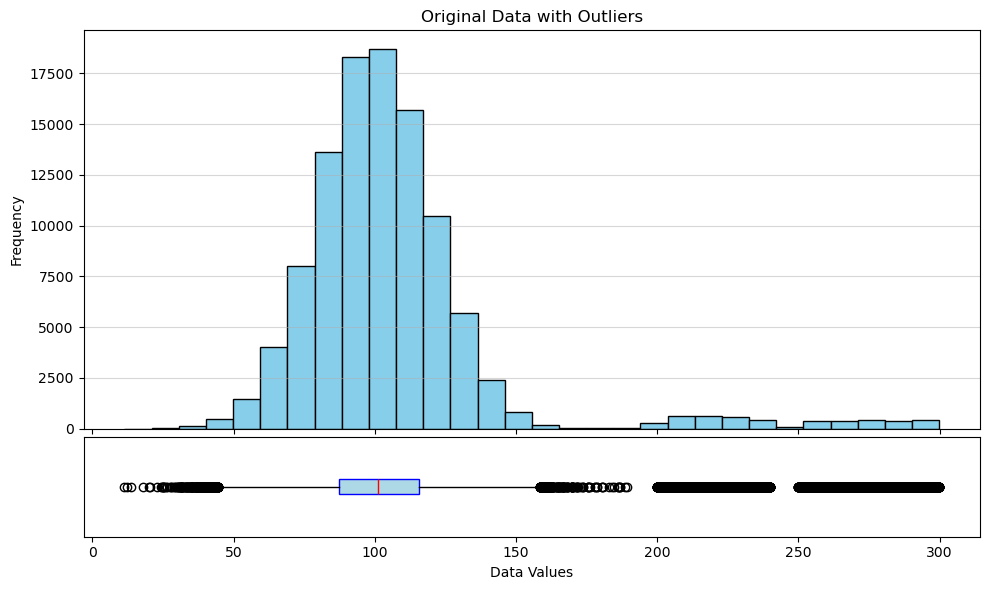

** After removing extreme outliers the data immediately becomes more concentrated and centrally focused


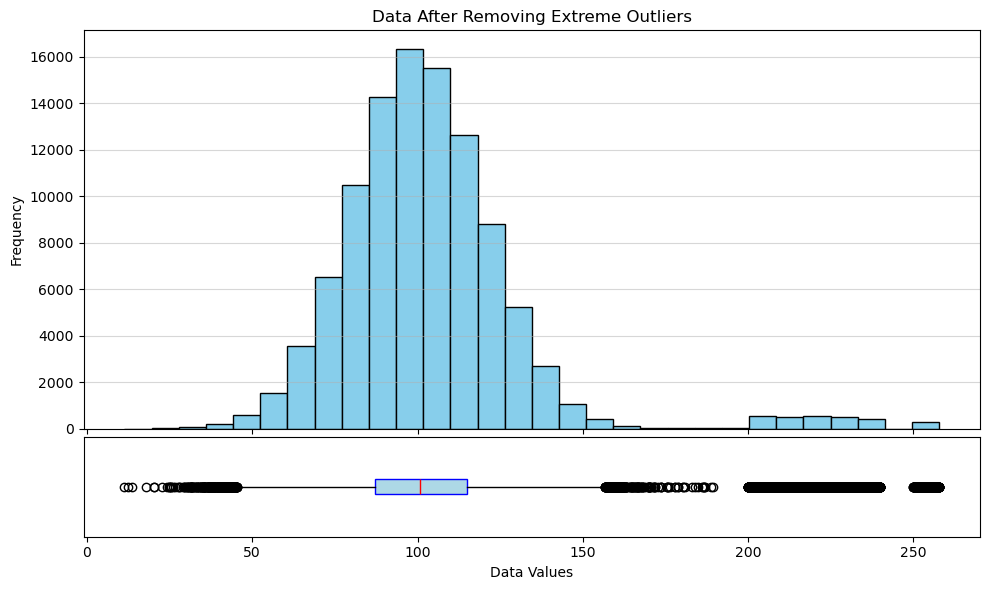

** Removing extreme & high outliers transformed the data distribution to a Normally distributed


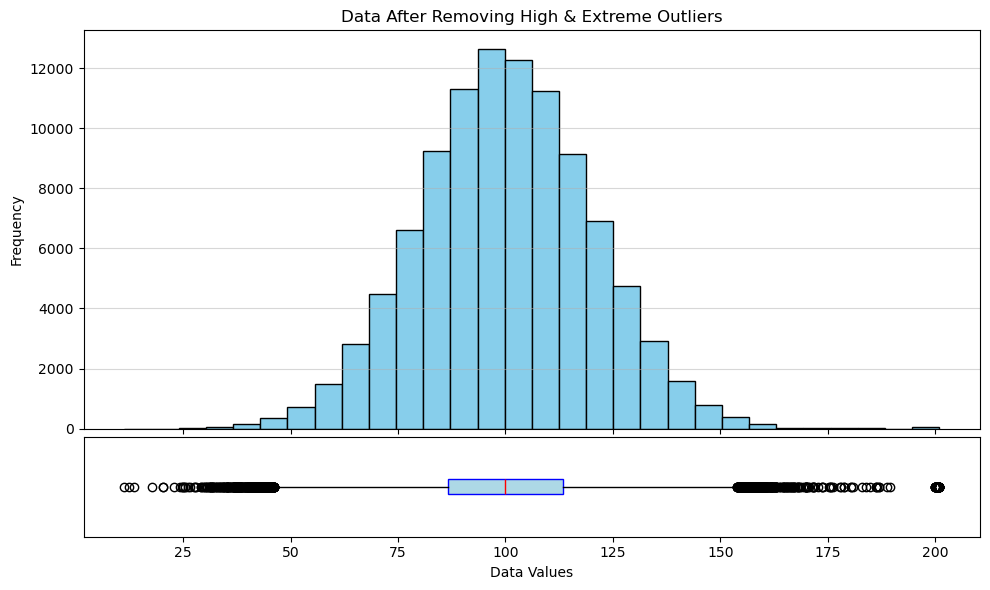

** Removing moderate outliers has a minimal influence on the overall disribution of data


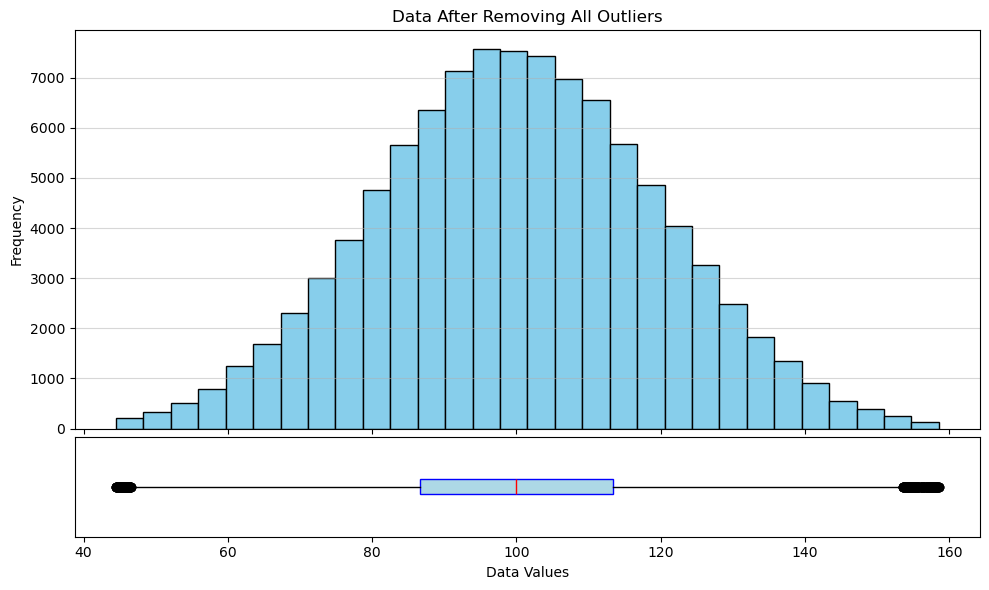


---Line plot showing the trend of Mean, Median, and Standard Deviation ---
** The StDev and Mean drop significantly after removing high & extreme outliers, 
    while the Median remains relatively flat, confirming its resistance to outliers.


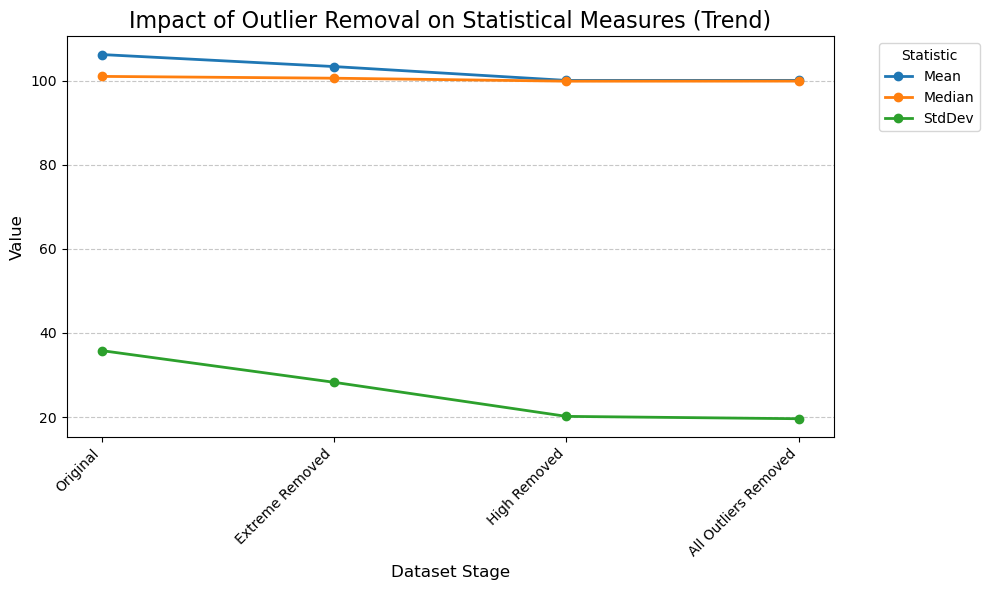


--- Detailed Outlier Report (First 10 Rows) ---
|   Data_Point |   Outlier_Score | Classification   |
|-------------:|----------------:|:-----------------|
|       11.328 |            2.67 | Moderate         |
|       12.29  |            2.64 | Moderate         |
|       13.531 |            2.59 | Moderate         |
|       17.794 |            2.44 | Moderate         |
|       20.198 |            2.36 | Moderate         |
|       20.361 |            2.35 | Moderate         |
|       22.758 |            2.27 | Moderate         |
|       24.343 |            2.21 | Moderate         |
|       24.725 |            2.2  | Moderate         |
|       24.956 |            2.19 | Moderate         |


In [3]:
# Analysis Report Output:
mydata()

### Analysis Discussion:

__Initial State: Original Data__
* The Original dataset is Right-Skewed  & highly dispersed, indicated by the large Standard Deviation (35.80).
There is a clear difference between the Mean (106.26) and the Median (101.06), showing the Mean is being pulled upwards by positive outliers. The large IQR (28.45) suggests a widely spread distribution.

__Stage 1: Extreme Outliers Removed__
* The removal of 1,697 Extreme outliers resulted in a highly significant reduction in Standard Deviation (drop of $\mathbf{7.54}$). The Mean also decreased substantially ($\mathbf{2.86}$), and the Median only shifted slightly ($101.06 \rightarrow 100.63$)
* the Extreme outliers were a significant source of distortion in the measure of spread (StdDev). The data immediately becomes more concentrated and centrally focused.

__Stage 2: High Outliers Removed__
* Removal of the most extreme values, & "High" outliers represented a larger cluster of influential points close to the $3 \times \text{IQR}$ fence. Their combined removal dramatically improved the symmetry of the core dataset distribution, moving the Mean closer to a central value ($103.40 \rightarrow 100.10$)
* Now the data looks alot more Normally distributed.

__Stage 3: All Outliers Removed__
* The removal of 514 Moderate outliers yielded only a marginal change. The Mean is not significantly changed ($\mathbf{-0.01}$ net difference), and the Standard Deviation saw a minor decrease ($\mathbf{0.56}$).
* This indicates that the core distribution was already stabilized after the removal of Extreme and High outliers. The remaining moderate points had minimal influence.

__Overall Conclusion  & Recommendations__

* __Effectiveness:__ The filtering process was highly effective, reducing the Standard Deviation by nearly $\mathbf{44\%}$ ($35.80 \rightarrow 20.15$), dramatically increasing the precision of the analysis.
* __Robustness__: The Median proved its robustness by changing only marginally ($\mathbf{1.12}$ total change) across the entire process, contrasting sharply with the Mean's total drop of $\mathbf{6.15}$.
  
* __Recommendations:__
  
While Step #2 removed most distortions and resulted in a stable set of core statistics, Deciding how to handle outliers depends on investigating their underlying cause. [Source](https://statisticsbyjim.com/basics/remove-outliers/)

* The proper action depends on what causes the outliers. There are three causes for outliers—data entry or measurement errors, sampling problems and unusual conditions (possible entry errors), and natural variations.

* __Example of a real world scenario of a Sampling problem__ where an outlier can be legitimately removed:

    * Here the  scientist explains that during a bone density study that he participated in, he noticed an outlier in the bone density growth for a subject. Her growth value was very unusual. The study’s subject coordinator discovered that the subject had diabetes, which affects bone health. the study’s goal was to model bone density growth in pre-adolescent girls with no health conditions that affect bone growth. Consequently, her data were excluded from the analyses because she was not a member of the target population. [Source](https://statisticsbyjim.com/basics/remove-outliers/)


* __Example of Natural Variation Causing an Outlier:__
    * Stock Market Volume (Index Rebalancing): On most days, the volume averages around 5 million shares. On one specific day, a major quarterly index rebalancing occurs, causing institutional funds to buy and sell massive blocks. The volume for that day hits 25 million shares.
    * It's a genuine transaction volume driven by a known, periodic, and naturally occurring financial event (index rebalancing) [Source](https://www.investopedia.com/index-rebalancing-7972596)



#### __Treatment of outliers :__ 
* Other methods of dealing with outliers, apart from removing them
from the dataset: [source](https://thedocs.worldbank.org/en/doc/20f02031de132cc3d76b91b5ed8737d0-0050012017/related/lecture-12-1.pdf)
1) reducing the weights of outliers (trimming weight)
2) changing the values of outliers (Winsorisation, trimming, imputation)
3) residual analysis, where treatment of outliers reduces residuals, hence fitting a Machine learning model better [Source](https://towardsdatascience.com/evaluating-the-impact-of-outlier-treatment-in-time-series-b4fac4cabe94/)
4) feature importance analysis to check whether core predictors remained stable despite adjustments in outliers.

* In Summary and for the sake of understanding how different outliers removal affects the overall distribution of data, for robustness and retaining maximum data points while eliminating significant distortion, keeping the "High Removed" dataset is a justifiable choice.
